## General imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

## Load dataframes

In [2]:
%%time

ratings = pd.read_parquet('ratings.snappy.parquet')
print(ratings.head(5))

users = pd.read_parquet('users.snappy.parquet')
print(users.head(5))

items = pd.read_parquet('movies.snappy.parquet')
print(items.head(5))

test_set = pd.read_parquet('test.snappy.parquet')
print(test_set.head(5))

train_set = pd.read_parquet('train.snappy.parquet')
print(train_set.head(5))

   user_id  item_id  rating
0        0     1192       5
1        0      660       3
2        0      913       3
3        0     3407       4
4        0     2354       5
   user_id gender  age  occupation zip_code
0        0      F    1          10    48067
1        1      M   56          16    70072
2        2      M   25          15    55117
3        3      M   45           7    02460
4        4      M   25          20    55455
   movie_id                         movie_title                         genre  \
0         0                    Toy Story (1995)   Animation|Children's|Comedy   
1         1                      Jumanji (1995)  Adventure|Children's|Fantasy   
2         2             Grumpier Old Men (1995)                Comedy|Romance   
3         3            Waiting to Exhale (1995)                  Comedy|Drama   
4         4  Father of the Bride Part II (1995)                        Comedy   

  release_year  
0         1995  
1         1995  
2         1995  
3         199

## Bipartite graph generation

In [3]:
def create_bipartite_adjacency_matrix(rating_dataframe):
    # Largest amount of nodes possible = zip code tripartite network
    max_nodes = len(users) + 3952  + users.zip_code.nunique()
    print("Largest amount of nodes possible: " + str(max_nodes))

    # Create an adjacency matrix with dimension max_nodes X max_nodes
        # First 6,040 entries are users, next 3,952 entries are items and 
        # the final 3,439 entries are reserved for the nodes in the intermediate layer of the tripartite network
    ret = np.zeros((max_nodes, max_nodes))

    # Aggregate sum of ratings for all users
    summed_ratings = rating_dataframe.drop(columns='item_id').groupby('user_id').sum()
    item_offset = 6040

    # Loop through all users
    for row in summed_ratings.itertuples():
        u_id = row[0]
        rating_total = row[1]

        # Query all ratings of the user
        user_ratings = rating_dataframe[rating_dataframe.user_id == u_id]

        for rating in user_ratings.itertuples():
            i_id = rating[2]
            r = rating[3]
            # Set edge weight to all rated items
            ret[u_id][item_offset + i_id] = r / rating_total
            ret[item_offset + i_id][u_id] = r / rating_total
            
    return ret

In [4]:
%%time
train_bipartite = create_bipartite_adjacency_matrix(train_set)
complete_bipartite = create_bipartite_adjacency_matrix(ratings)

Largest amount of nodes possible: 13431
Largest amount of nodes possible: 13431
Wall time: 28.1 s


In [17]:
def create_simple_bipartite_adjacency(rating_dataframe):
    # Largest amount of nodes possible = zip code tripartite network
    max_nodes = len(users) + 3952  + users.zip_code.nunique()
    print("Largest amount of nodes possible: " + str(max_nodes))

    # Create an adjacency matrix with dimension max_nodes X max_nodes
        # First 6,040 entries are users, next 3,952 entries are items and 
        # the final 3,439 entries are reserved for the nodes in the intermediate layer of the tripartite network
    ret = np.zeros((max_nodes, max_nodes))
    
    item_offset = 6040
    
    for row in rating_dataframe.itertuples():
        u_id = row[1]
        i_id = row[2]
        r = row[3]
        
        ret[u_id][item_offset + i_id] = r
        ret[item_offset + i_id][u_id] = r
        
    return ret

In [18]:
%%time
train_simple_bipartite = create_simple_bipartite_adjacency(train_set)
complete_simple_bipartite = create_simple_bipartite_adjacency(ratings)

Largest amount of nodes possible: 13431
Largest amount of nodes possible: 13431
Wall time: 2.97 s


## Tripartite graph creation

### Full genres

In [5]:
def create_full_genres_adjacency_matrix(bipartite_baseline, rating_dataframe):
    ret = bipartite_baseline.copy()
    item_offset = 6040
    intermediate_offset = 6040 + 3952

    # Join ratings and movies on movie_id
    movie_ratings = pd.merge(rating_dataframe, items, left_on='item_id', right_on='movie_id').drop(columns=['movie_id', 'movie_title', 'release_year'])
    print(f'Number of Ratings: \t{len(movie_ratings):,}\nUnique Users: \t\t{movie_ratings.user_id.nunique()}\nUnique Items: \t\t{movie_ratings.item_id.nunique():,}\nUnique genres: \t\t{movie_ratings.genre.nunique():,}')

    # Calculate average ratings per movie
    avg_movie_ratings = movie_ratings.drop(columns=['user_id']).groupby(['item_id', 'genre']).mean()

    # Calculate total movie ratings per full genre (used for normalization)
    total_full_genre_movie_ratings = avg_movie_ratings.groupby('genre').sum()

    # Map genre combinations to indices
    full_genres_indices = {}
    full_genre_index = 0
    for row in total_full_genre_movie_ratings.itertuples():
        g = row[0]
        r = row[1]
        full_genres_indices[g] = (full_genre_index, r)
        full_genre_index += 1

    # Calculate the average ratings of users to genre combinations
    avg_full_user_ratings = movie_ratings.drop(columns=['item_id']).groupby(['user_id', 'genre']).mean()

    # Calculate total ratings of users to full genres (used for normalisation)
    total_full_user_ratings = avg_full_user_ratings.groupby('user_id').sum()

    # Loop through all average user ratings and update edge weights to full genres
    for row in avg_full_user_ratings.itertuples():
        u_id = row[0][0]
        g = row[0][1]
        user_genre_rating = row[1]

        g_index, total_genre_rating = full_genres_indices[g]

        user_total_avg_rating = total_full_user_ratings.at[u_id, 'rating']

        ret[u_id][intermediate_offset + g_index] = user_genre_rating / user_total_avg_rating
        ret[intermediate_offset + g_index][u_id] = user_genre_rating / user_total_avg_rating

    # Loop through all average movie ratings and update weights to genre combinations
    for row in avg_movie_ratings.itertuples():
        i_id = row[0][0]
        g = row[0][1]
        avg_movie_rating = row[1]

        g_index, total_genre_rating = full_genres_indices[g]

        ret[intermediate_offset + g_index][item_offset + i_id] = avg_movie_rating / total_genre_rating
        ret[item_offset + i_id][intermediate_offset + g_index] = avg_movie_rating / total_genre_rating
        
    return ret

In [7]:
%%time
train_full_genres = create_full_genres_adjacency_matrix(train_bipartite, train_set)
complete_full_genres = create_full_genres_adjacency_matrix(complete_bipartite, ratings)

Number of Ratings: 	996,209
Unique Users: 		6040
Unique Items: 		3,706
Unique genres: 		301
1.9999999999999996
Number of Ratings: 	1,000,209
Unique Users: 		6040
Unique Items: 		3,706
Unique genres: 		301
1.9999999999999996
Wall time: 8.66 s


### Basic genres

In [19]:
def create_basic_genres_adjacency_matrix(bipartite_baseline, rating_dataframe):
    ret = bipartite_baseline.copy()
    item_offset = 6040
    intermediate_offset = 6040 + 3952
    
    # Join ratings and movies on movie_id
    movie_ratings = pd.merge(rating_dataframe, items, left_on='item_id', right_on='movie_id').drop(columns=['movie_id', 'movie_title', 'release_year'])
    
    # Split up entries in movie dataframe to have a single basic genre per movie
    split_movies = movie_ratings.drop(columns='genre').join(movie_ratings['genre'].str.split('|', expand=True).stack().reset_index(level=1, drop=True).rename('genre'))
    
    # Calculate amount of ratings and average ratings for each user to all genres
    user_basic_genre_ratings = split_movies.drop(columns='item_id').groupby(['user_id', 'genre']).agg(['count', 'mean']).reset_index()
    
    # Map basic genres to indices
    basic_genre_indices = {
        "Action": 0,
        "Adventure": 1,
        "Animation": 2,
        "Children's": 3,
        "Comedy": 4,
        "Crime": 5,
        "Documentary": 6,
        "Drama": 7,
        "Fantasy": 8,
        "Film-Noir": 9,
        "Horror": 10,
        "Musical": 11,
        "Mystery": 12,
        "Romance": 13,
        "Sci-Fi": 14,
        "Thriller": 15,
        "War": 16,
        "Western": 17
    }

    # Loop through all users and update weights to basic genres
    for row in user_basic_genre_ratings.itertuples():
        u_id = row[1]
        genre = row[2]
        count = row[3]
        average = row[4]
        
        temp = user_basic_genre_ratings[user_basic_genre_ratings.user_id == u_id].groupby('user_id').mean().values[0]
        average_rating_amount = temp[0] # av(u)
        average_rating = temp[1] # ar(u)
        
        genre_index = basic_genre_indices[genre]
        
        ret[u_id][intermediate_offset + genre_index] = ((average_rating_amount * average_rating) + (count * average)) / (average_rating_amount + count)
        ret[intermediate_offset + genre_index][u_id] = ((average_rating_amount * average_rating) + (count * average)) / (average_rating_amount + count)
        
    # Calculate the average rating per movie    
    average_movie_ratings = split_movies.drop(columns='user_id').groupby(['item_id', 'genre']).mean().reset_index()

    # Loop through all movies and update weights to basic genres
    for row in average_movie_ratings.itertuples():
        i_id = row[1]
        genre = row[2]
        average_rating = row[3]
        
        genre_index = basic_genre_indices[genre]
        
        genre_count = len(items[items.movie_id==i_id].values[0][2].split("|"))
        
        ret[item_offset + i_id][intermediate_offset + genre_index] = average_rating / genre_count
        ret[intermediate_offset + genre_index][item_offset + i_id] = average_rating / genre_count
        
    return ret

In [20]:
%%time
train_basic_genres = create_basic_genres_adjacency_matrix(train_simple_bipartite, train_set)
complete_basic_genres = create_basic_genres_adjacency_matrix(complete_simple_bipartite, ratings)

C:\Users\tccru\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


Wall time: 1h 39s


In [21]:
%%time

# Save basic genre adjacency matrix (takes very long to compute)
np.save('train_basic_genres', train_basic_genres)
np.save('complete_basic_genres', complete_basic_genres)

Wall time: 5.64 s


In [62]:
%%time

# Load the basic genre adjacency matrix from file
train_basic_genres = np.load('train_basic_genres.npy')
complete_basic_genres = np.load('complete_basic_genres.npy')

Wall time: 1.91 s


In [64]:
%%time

# Basic genre weight normalisation
for i in range(6040):
    total = np.sum(train_basic_genres[i][6040+3952:6040+3952+18])
    train_basic_genres[i][6040+3952:6040+3952+18] = train_basic_genres[i][6040+3952:6040+3952+18] / total
    
for x in range(len(train_basic_genres)):
    row = train_basic_genres[x]
    for y in range(len(row)):
        train_basic_genres[y][x] = row[y]


Wall time: 1min 23s


In [74]:
print(users.head(10))
print(train_basic_genres[6040+3952:6040+3952+18][0])

   user_id gender  age  occupation zip_code
0        0      F    1          10    48067
1        1      M   56          16    70072
2        2      M   25          15    55117
3        3      M   45           7    02460
4        4      M   25          20    55455
5        5      F   50           9    55117
6        6      M   35           1    06810
7        7      M   25          12    11413
8        8      M   25          17    61614
9        9      F   35           1    95370
[0.07712265 0.06962095 0.06758127 ... 0.         0.         0.        ]


### Release year

In [5]:
def create_release_year_adjacency_matrix(bipartite_baseline, rating_dataframe):
    ret = bipartite_baseline.copy()
    item_offset = 6040
    intermediate_offset = 6040 + 3952

    # Join ratings and movies on movie_id
    movie_ratings = pd.merge(rating_dataframe, items, left_on='item_id', right_on='movie_id').drop(columns=['movie_id', 'movie_title', 'genre'])
    print(f'Number of Ratings: \t{len(movie_ratings):,}\nUnique Users: \t\t{movie_ratings.user_id.nunique()}\nUnique Items: \t\t{movie_ratings.item_id.nunique():,}\nUnique release years: \t{movie_ratings.release_year.nunique():,}')

    # Calculate average ratings per movie
    avg_movie_ratings = movie_ratings.drop(columns=['user_id']).groupby(['item_id', 'release_year']).mean()

    # Calculate total movie ratings per release year (used for normalization)
    total_year_movie_ratings = avg_movie_ratings.groupby('release_year').sum()

    # Map genre combinations to indices
    year_indices = {}
    year_index = 0
    for row in total_year_movie_ratings.itertuples():
        y = row[0]
        r = row[1]
        year_indices[y] = (year_index, r)
        year_index += 1

    # Calculate the average ratings of users to release years
    avg_year_user_ratings = movie_ratings.drop(columns=['item_id']).groupby(['user_id', 'release_year']).mean()

    # Calculate total ratings of users to release years (used for normalisation)
    total_year_user_ratings = avg_year_user_ratings.groupby('user_id').sum()

    # Loop through all average user ratings and update edge weights to release years
    for row in avg_year_user_ratings.itertuples():
        u_id = row[0][0]
        y = row[0][1]
        user_year_rating = row[1]

        y_index, total_year_rating = year_indices[y]

        user_total_avg_rating = total_year_user_ratings.at[u_id, 'rating']

        ret[u_id][intermediate_offset + y_index] = user_year_rating / user_total_avg_rating
        ret[intermediate_offset + y_index][u_id] = user_year_rating / user_total_avg_rating

    # Loop through all average movie ratings and update weights to release years
    for row in avg_movie_ratings.itertuples():
        i_id = row[0][0]
        y = row[0][1]
        avg_movie_rating = row[1]

        y_index, total_year_rating = year_indices[y]

        ret[intermediate_offset + y_index][item_offset + i_id] = avg_movie_rating / total_year_rating
        ret[item_offset + i_id][intermediate_offset + y_index] = avg_movie_rating / total_year_rating
        
    return ret

In [6]:
%%time
train_release_year = create_release_year_adjacency_matrix(train_bipartite, train_set)
complete_release_year = create_release_year_adjacency_matrix(complete_bipartite, ratings)

Number of Ratings: 	996,209
Unique Users: 		6040
Unique Items: 		3,706
Unique release years: 	81
Number of Ratings: 	1,000,209
Unique Users: 		6040
Unique Items: 		3,706
Unique release years: 	81
Wall time: 5.61 s


### Gender

In [5]:
def create_gender_adjacency_matrix(bipartite_baseline, rating_dataframe):
    ret = bipartite_baseline.copy()
    item_offset = 6040
    intermediate_offset = 6040 + 3952

    # Join ratings and users on user_id
    user_ratings = pd.merge(rating_dataframe, users, left_on='user_id', right_on='user_id').drop(columns=['age', 'occupation', 'zip_code'])
    print(f'Number of Ratings: \t{len(user_ratings):,}\nUnique Users: \t\t{user_ratings.user_id.nunique()}\nUnique genders: \t{user_ratings.gender.nunique():,}')

    # Calculate average ratings per movie per gender
    avg_gender_movie_ratings = user_ratings.drop(columns=['user_id']).groupby(['gender', 'item_id']).mean()

    # Calculate total movie ratings per gender (used for normalization)
    total_gender_ratings = avg_gender_movie_ratings.groupby(['gender']).sum()
    M_total = total_gender_ratings.at['M', 'rating']
    F_total = total_gender_ratings.at['F', 'rating']

    # Map genders to indices
    gender_indices = {'M': (0, M_total, 4331), 'F': (1, F_total, 1709)}

    # Loop through all users and update weights to genders
    for row in users.itertuples():
        u_id = row[1]
        gender = row[2]

        gender_index, gender_total, gender_count = gender_indices[gender]

        ret[u_id][intermediate_offset + gender_index] = 1 / gender_count
        ret[intermediate_offset + gender_index][u_id] = 1 / gender_count

    # Loop through all movies and update weights to genders
    for row in avg_gender_movie_ratings.itertuples():
        gender = row[0][0]
        i_id = row[0][1]
        rating = row[1]

        gender_index, gender_total, gender_count = gender_indices[gender]

        ret[intermediate_offset + gender_index][item_offset + i_id] = rating / gender_total
        ret[item_offset + i_id][intermediate_offset + gender_index] = rating / gender_total
        
    return ret

In [13]:
print(users.drop(columns=['age', 'occupation', 'zip_code']).groupby(['gender']).count())

        user_id
gender         
F          1709
M          4331


In [6]:
%%time
train_gender = create_gender_adjacency_matrix(train_bipartite, train_set)
complete_gender = create_gender_adjacency_matrix(complete_bipartite, ratings)

Number of Ratings: 	996,209
Unique Users: 		6040
Unique genders: 	2
Number of Ratings: 	1,000,209
Unique Users: 		6040
Unique genders: 	2
Wall time: 2.94 s


### Age

In [16]:
def create_age_adjacency_matrix(bipartite_baseline, rating_dataframe):
    ret = bipartite_baseline.copy()
    item_offset = 6040
    intermediate_offset = 6040 + 3952
    
    # Join ratings and users on user_id
    user_ratings = pd.merge(rating_dataframe, users, left_on='user_id', right_on='user_id').drop(columns=['gender', 'occupation', 'zip_code'])
    print(f'Number of Ratings: \t{len(user_ratings):,}\nUnique Users: \t\t{user_ratings.user_id.nunique()}\nUnique ages: \t\t{user_ratings.age.nunique():,}')

    # Calculate average ratings per movie per age group
    avg_age_movie_ratings = user_ratings.drop(columns=['user_id']).groupby(['age', 'item_id']).mean()
    
    # Calculate total movie ratings per age group (used for normalization)
    total_age_ratings = avg_age_movie_ratings.groupby(['age']).sum()
    
    # Map age groups to indices
    age_indices = {}
    age_index = 0
    for row in total_age_ratings.itertuples():
        a = row[0]
        r = row[1]
        age_count = users[users.age == a]['age'].count()
        age_indices[a] = (age_index, r, age_count)
        age_index += 1
        
    # Loop through all users and update weights to age groups
    for row in users.itertuples():
        u_id = row[1]
        age = row[3]

        age_index, age_total, age_count = age_indices[age]

        ret[u_id][intermediate_offset + age_index] = 1 / age_count
        ret[intermediate_offset + age_index][u_id] = 1 / age_count
        
    # Loop through all movies and update weights to age groups
    for row in avg_age_movie_ratings.itertuples():
        age = row[0][0]
        i_id = row[0][1]
        rating = row[1]

        age_index, age_total, age_count = age_indices[age]

        ret[intermediate_offset + age_index][item_offset + i_id] = rating / age_total
        ret[item_offset + i_id][intermediate_offset + age_index] = rating / age_total
        
    return ret

In [17]:
%%time
train_age = create_age_adjacency_matrix(train_bipartite, train_set)
complete_age = create_age_adjacency_matrix(complete_bipartite, ratings)

Number of Ratings: 	996,209
Unique Users: 		6040
Unique ages: 		7
Number of Ratings: 	1,000,209
Unique Users: 		6040
Unique ages: 		7
Wall time: 4.59 s


### Occupation

In [20]:
def create_occupation_adjacency_matrix(bipartite_baseline, rating_dataframe):
    ret = bipartite_baseline.copy()
    item_offset = 6040
    intermediate_offset = 6040 + 3952
    
    # Join ratings and users on user_id
    user_ratings = pd.merge(rating_dataframe, users, left_on='user_id', right_on='user_id').drop(columns=['gender', 'age', 'zip_code'])
    print(f'Number of Ratings: \t{len(user_ratings):,}\nUnique Users: \t\t{user_ratings.user_id.nunique()}\nUnique occupations: \t{user_ratings.occupation.nunique():,}')
    
    # Calculate average ratings per movie per occupation
    avg_occupation_movie_ratings = user_ratings.drop(columns=['user_id']).groupby(['occupation', 'item_id']).mean()
    
    # Calculate total movie ratings per occupation (used for normalization)
    total_occupation_ratings = avg_occupation_movie_ratings.groupby(['occupation']).sum()
    
    # Map occupations to indices
    occupation_indices = {}
    occupation_index = 0
    for row in total_occupation_ratings.itertuples():
        o = row[0]
        r = row[1]
        occupation_count = users[users.occupation == o]['occupation'].count()
        occupation_indices[o] = (occupation_index, r, occupation_count)
        occupation_index += 1

    # Loop through all users and update weights to occupations
    for row in users.itertuples():
        u_id = row[1]
        occupation = row[4]

        occupation_index, occupation_total, occupation_count = occupation_indices[occupation]

        ret[u_id][intermediate_offset + occupation_index] = 1 / occupation_count
        ret[intermediate_offset + occupation_index][u_id] = 1 / occupation_count
        
    # Loop through all movies and update weights to occupations
    for row in avg_occupation_movie_ratings.itertuples():
        occupation = row[0][0]
        i_id = row[0][1]
        rating = row[1]

        occupation_index, occupation_total, occupation_count = occupation_indices[occupation]

        ret[intermediate_offset + occupation_index][item_offset + i_id] = rating / occupation_total
        ret[item_offset + i_id][intermediate_offset + occupation_index] = rating / occupation_total
        
    return ret

In [21]:
%%time
train_occupation = create_occupation_adjacency_matrix(train_bipartite, train_set)
complete_occupation = create_occupation_adjacency_matrix(complete_bipartite, ratings)

Number of Ratings: 	996,209
Unique Users: 		6040
Unique occupations: 	21
Number of Ratings: 	1,000,209
Unique Users: 		6040
Unique occupations: 	21
Wall time: 4.66 s


### Zip code

In [5]:
def create_zip_code_adjacency_matrix(bipartite_baseline, rating_dataframe):
    ret = bipartite_baseline.copy()
    item_offset = 6040
    intermediate_offset = 6040 + 3952
    
    # Join ratings and users on user_id
    user_ratings = pd.merge(rating_dataframe, users, left_on='user_id', right_on='user_id').drop(columns=['gender', 'age', 'occupation'])
    print(f'Number of Ratings: \t{len(user_ratings):,}\nUnique Users: \t\t{user_ratings.user_id.nunique()}\nUnique zip codes: \t{user_ratings.zip_code.nunique():,}')
    
    # Calculate average ratings per movie per zip code
    avg_zip_code_movie_ratings = user_ratings.drop(columns=['user_id']).groupby(['zip_code', 'item_id']).mean()
    
    # Calculate total movie ratings per zip code (used for normalization)
    total_zip_code_ratings = avg_zip_code_movie_ratings.groupby(['zip_code']).sum()
    
    # Map occupations to indices
    zip_code_indices = {}
    zip_code_index = 0
    for row in total_zip_code_ratings.itertuples():
        zc = row[0]
        r = row[1]
        zip_code_count = users[users.zip_code == zc]['zip_code'].count()
        zip_code_indices[zc] = (zip_code_index, r, zip_code_count)
        zip_code_index += 1
        
    # Loop through all users and update weights to zip codes
    for row in users.itertuples():
        u_id = row[1]
        zip_code = row[5]

        zip_code_index, zip_code_total, zip_code_count = zip_code_indices[zip_code]

        ret[u_id][intermediate_offset + zip_code_index] = 1 / zip_code_count
        ret[intermediate_offset + zip_code_index][u_id] = 1 / zip_code_count
        
    # Loop through all movies and update weights to occupations
    for row in avg_zip_code_movie_ratings.itertuples():
        zip_code = row[0][0]
        i_id = row[0][1]
        rating = row[1]

        zip_code_index, zip_code_total, zip_code_count = zip_code_indices[zip_code]

        ret[intermediate_offset + zip_code_index][item_offset + i_id] = rating / zip_code_total
        ret[item_offset + i_id][intermediate_offset + zip_code_index] = rating / zip_code_total
        
    return ret

In [6]:
%%time
train_zip_code = create_zip_code_adjacency_matrix(train_bipartite, train_set)
complete_zip_code = create_zip_code_adjacency_matrix(complete_bipartite, ratings)

Number of Ratings: 	996,209
Unique Users: 		6040
Unique zip codes: 	3,439
Number of Ratings: 	1,000,209
Unique Users: 		6040
Unique zip codes: 	3,439
Wall time: 13 s


## Recommendation

In [39]:
%%time

# Multiply the bipartite adjacency matrix to simulate random walk
multiplied = np.matmul(genres_elaborate, np.matmul(genres_elaborate, genres_elaborate))

# Get the top n recommendations for a user
user_id = 38
n = 20
recommendations = np.argpartition(multiplied[user_id][6040:(6040 + 3952)], -n)[-n:] # contains the movie_id's of the top n items
values = multiplied[user_id][recommendations + 6040]
print(recommendations)
print(values)

[2570  479 1197  607  588  317  857 1616 2395 2027 1209 1195  259 2761
 2857  592 2996  526 3577  109]
[0.30640102 0.31682812 0.31306279 0.32743107 0.31998355 0.34000455
 0.3104457  0.343981   0.40136626 0.43319299 0.38794812 0.34719552
 0.39558841 0.49238543 0.83199758 0.41026445 0.45751695 0.35828944
 0.36218926 0.37185314]
Wall time: 1min 20s


## Recall@N

In [7]:
# parameter markov_matrix is used to get the recommendation scores
def evaluate_recall(markov_matrix):
    # Initialise result data structure (array containing hits per interval)
    results = np.zeros(50)
    
    # Loop through all 4000 five star ratings
    for row in test_set.itertuples():
        u_id = row[1]
        i_id = row[2]

        # Randomly select 1000 items not rated by the user
        rated = ratings[ratings.user_id == u_id]['item_id'].values.tolist()
        not_rated = items.drop(items[items.movie_id.isin(rated)].index).sample(1000)['movie_id'].to_numpy()
        not_rated = np.append(not_rated, i_id)

        # Get predicted scores from the multiplied matrix
        predicted = markov_matrix[u_id][not_rated + 6040]

        # Find rank of item in question
        ranks = predicted.argsort()
        rank = np.where(ranks == 1000)[0]

        # Increment hits up from rank
        for i in range(50):
            if 1000 - rank <= i + 1:
                results[i] += 1
                    
    return results / len(test_set)

## Diversity

In [8]:
def evaluate_diversity(markov_matrix):
    repetitions = 100
    diversity = np.zeros(repetitions)
    
    # Take the average of 100 diversity calculations
    for d in range(repetitions):
        # Sample 200 test users
        test_users = users.sample(200)

        # Extract the user ids of the test users
        test_user_ids = test_users['user_id'].to_numpy()

        # Create a set to store all recommendations
        recommendations = set()

        # For each user, find the top 10 recommendations and add them to the set
        for u_id in test_user_ids:
            # Get the ids of the movies already rated by the user
            previously_rated = ratings[ratings.user_id == u_id]['item_id'].to_numpy()

            # Get the recommendation values for the movies unrated by the user
            rec = np.delete(markov_matrix[u_id][6040:(6040 + 3952)], previously_rated)

            # Get the top 10 recommendations
            top10 = np.argpartition(rec, -10)[-10:] # contains the movie_id's of the top 10 items
            for i_id in top10:
                recommendations.add(i_id)

        # Calculate Diversity metric
        diversity[d] = len(recommendations) / 2000
    
    return (np.mean(diversity), np.std(diversity))

## Results

In [9]:
# Adjacency matrix contains the information of the graph that is used to generate the results
def generate_results(adjacency_matrix):
    print('Starting t3 multiplication')
    multiplied = adjacency_matrix @ adjacency_matrix @ adjacency_matrix
    
    print('Starting t3 evaluation')
    t3_recall = evaluate_recall(multiplied)
    t3_mean_diversity, t3_std_diversity = evaluate_diversity(multiplied)
    
    print('Starting t5 multiplication')
    multiplied = multiplied @ adjacency_matrix @ adjacency_matrix
    
    print('Starting t5 evaluation')
    t5_recall = evaluate_recall(multiplied)
    t5_mean_diversity, t5_std_diversity = evaluate_diversity(multiplied)
    
    print('Starting t7 multiplication')
    multiplied = multiplied @ adjacency_matrix @ adjacency_matrix
    
    print('Starting t7 evaluation')
    t7_recall = evaluate_recall(multiplied)
    t7_mean_diversity, t7_std_diversity = evaluate_diversity(multiplied)
    
    return (t3_recall, t3_mean_diversity, t3_std_diversity, t5_recall, t5_mean_diversity, t5_std_diversity, t7_recall, t7_mean_diversity, t7_std_diversity)

In [10]:
%%time

# The graph that is evaluated is specified here
focus_graph = normalize(train_zip_code, axis=1, norm='l1')

t3r, t3md, t3sdd, t5r, t5md, t5sdd, t7r, t7md, t7sdd = generate_results(focus_graph.copy())

Starting t3 multiplication
Starting t3 evaluation
Starting t5 multiplication
Starting t5 evaluation
Starting t7 multiplication
Starting t7 evaluation
Wall time: 7min 7s


Mean diversity of T3: 0.53818
Standard deviation of diversity of T3: 0.01167379972416866
Mean diversity of T5: 0.48620499999999994
Standard deviation of diversity of T5: 0.012571812717345096
Mean diversity of T7: 0.470595
Standard deviation of diversity of T7: 0.016091565337157217
[0.13875, 0.1765, 0.20825, 0.23175, 0.258, 0.28, 0.297, 0.31, 0.33075, 0.3445, 0.362, 0.3735, 0.3905, 0.405, 0.418, 0.4285, 0.4425, 0.45625, 0.4655, 0.474, 0.48425, 0.49375, 0.50175, 0.51275, 0.51975, 0.53025, 0.5385, 0.5465, 0.55425, 0.56425, 0.56925, 0.57775, 0.5825, 0.587, 0.59325, 0.596, 0.60025, 0.606, 0.611, 0.6175, 0.623, 0.6275, 0.634, 0.63975, 0.64325, 0.64775, 0.6505, 0.6545, 0.65825, 0.66225]
[0.12275, 0.155, 0.18125, 0.2065, 0.232, 0.257, 0.27275, 0.2915, 0.305, 0.31925, 0.332, 0.34375, 0.35725, 0.3685, 0.38125, 0.391, 0.40125, 0.4105, 0.418, 0.42675, 0.4335, 0.44275, 0.452, 0.45975, 0.466, 0.4715, 0.48125, 0.492, 0.4995, 0.50725, 0.51225, 0.516, 0.52375, 0.52875, 0.53475, 0.54075, 0.548, 0.55275,

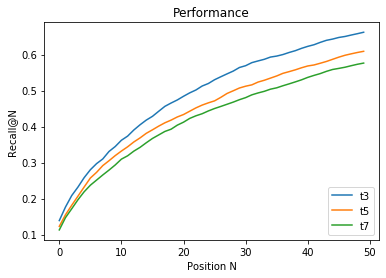

In [11]:
print('Mean diversity of T3: ' + str(t3md))
print('Standard deviation of diversity of T3: ' + str(t3sdd))
print('Mean diversity of T5: ' + str(t5md))
print('Standard deviation of diversity of T5: ' + str(t5sdd))
print('Mean diversity of T7: ' + str(t7md))
print('Standard deviation of diversity of T7: ' + str(t7sdd))

plt.plot(t3r, label='t3')
plt.plot(t5r, label='t5')
plt.plot(t7r, label='t7')
plt.title('Performance')
plt.legend(loc='lower right')
plt.xlabel('Position N')
plt.ylabel('Recall@N')

print(t3r.tolist())
print(t5r.tolist())
print(t7r.tolist())

In [8]:
def create_dumb_basic_genres_adjacency_matrix(bipartite_baseline, rating_dataframe):
    ret = bipartite_baseline.copy()
    item_offset = 6040
    intermediate_offset = 6040 + 3952
    
    # Join ratings and movies on movie_id
    movie_ratings = pd.merge(rating_dataframe, items, left_on='item_id', right_on='movie_id').drop(columns=['movie_id', 'movie_title', 'release_year'])
    
    # Split up entries in movie dataframe to have a single basic genre per movie
    split_movies = movie_ratings.drop(columns='genre').join(movie_ratings['genre'].str.split('|', expand=True).stack().reset_index(level=1, drop=True).rename('genre'))
    
    # Calculate the average rating per movie    
    average_movie_ratings = split_movies.drop(columns='user_id').groupby(['item_id', 'genre']).mean()
    
    # Calculate total ratings per basic genres (used for normalisation)
    total_basic_genre_ratings = average_movie_ratings.groupby('genre').sum()
    
    # Map basic genres to indices
    basic_genre_indices = {}
    basic_genre_index = 0
    for row in total_basic_genre_ratings.itertuples():
        genre = row[0]
        total_rating = row[1]
        basic_genre_indices[genre] = (basic_genre_index, total_rating)
        basic_genre_index += 1
        
    # Calculate the average ratings of users to genre combinations    
    user_basic_genre_ratings = split_movies.drop(columns='item_id').groupby(['user_id', 'genre']).mean()
    
    # Calculate total ratings of users to full genres (used for normalisation)
    total_basic_user_ratings = user_basic_genre_ratings.groupby('user_id').sum()
    
    # Loop through all users and update weights to basic genres
    for row in user_basic_genre_ratings.itertuples():
        u_id = row[0][0]
        genre = row[0][1]
        user_genre_rating = row[1]

        g_index, total_genre_rating = basic_genre_indices[genre]

        user_total_avg_rating = total_basic_user_ratings.at[u_id, 'rating']
    
        ret[u_id][intermediate_offset + g_index] = user_genre_rating / user_total_avg_rating
        ret[intermediate_offset + g_index][u_id] = user_genre_rating / user_total_avg_rating
    
    # Loop through all movies and update weights to basic genres
    for row in average_movie_ratings.itertuples():
        i_id = row[0][0]
        genre = row[0][1]
        average_rating = row[1]
        
        g_index, total_genre_rating = basic_genre_indices[genre]
        
        ret[item_offset + i_id][intermediate_offset + g_index] = average_rating / total_genre_rating
        ret[intermediate_offset + g_index][item_offset + i_id] = average_rating / total_genre_rating
    
    return ret